# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, LeakyReLU, BatchNormalization, Input, Concatenate, Activation, concatenate
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model
import numpy as np
import cv2
import PIL
from PIL import Image
import random
import h5py
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
def create_model(image_shape):
    # Prepare the kernel initializer values
    weight_init = RandomNormal(stddev=0.02)
    # Prepare the Input layer
    net_input = Input((image_shape))
    # Download mobile net, and use it as the base.
    mobile_net_base = MobileNetV2(
        include_top=False,
        input_shape=image_shape,
        weights='imagenet'
    )
    mobilenet = mobile_net_base(net_input)
    
    # Encoder block #
    # 224x224
    conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(net_input)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 112x112
    conv2 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)

    # 112x112
    conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv2)
    conv3 =  Activation('relu')(conv3)

    # 56x56
    conv4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv3)
    conv4 = Activation('relu')(conv4)

    # 28x28
    conv4_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(conv4)
    conv4_ = Activation('relu')(conv4_)

    # 28x28
    conv5 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv4_)
    conv5 = Activation('relu')(conv5)

    # 14x14
    conv5_ = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(conv5)
    conv5_ = Activation('relu')(conv5_)
    
    #7x7
    # Fusion layer - Connects MobileNet with our encoder
    conc = concatenate([mobilenet, conv5_])
    fusion = Conv2D(512, (1, 1), padding='same', kernel_initializer=weight_init)(conc)
    fusion = Activation('relu')(fusion)
    
    # Skip fusion layer
    skip_fusion = concatenate([fusion, conv5_])
    
    # Decoder block #
    # 7x7
    decoder = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_fusion)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # Skip layer from conv5 (with added dropout)
    skip_4_drop = Dropout(0.25)(conv5)
    skip_4 = concatenate([decoder, skip_4_drop])
    
    # 14x14
    decoder = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_4)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # Skip layer from conv4_ (with added dropout)
    skip_3_drop = Dropout(0.25)(conv4_)
    skip_3 = concatenate([decoder, skip_3_drop])
    
    # 28x28
    decoder = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(skip_3)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # 56x56
    decoder = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Dropout(0.25)(decoder)

    # 112x112
    decoder = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)

    # 112x112
    decoder = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(decoder)
    decoder = Activation('relu')(decoder)
    
    # 224x224
    # Ooutput layer, with 2 channels (a and b)
    output_layer = Conv2D(2, (1, 1), activation='tanh')(decoder)

    model = Model(net_input, output_layer)
    model.compile(Adam(lr=0.0002), loss='mse', metrics=['accuracy'])
    
    return model

9406464/9406464 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


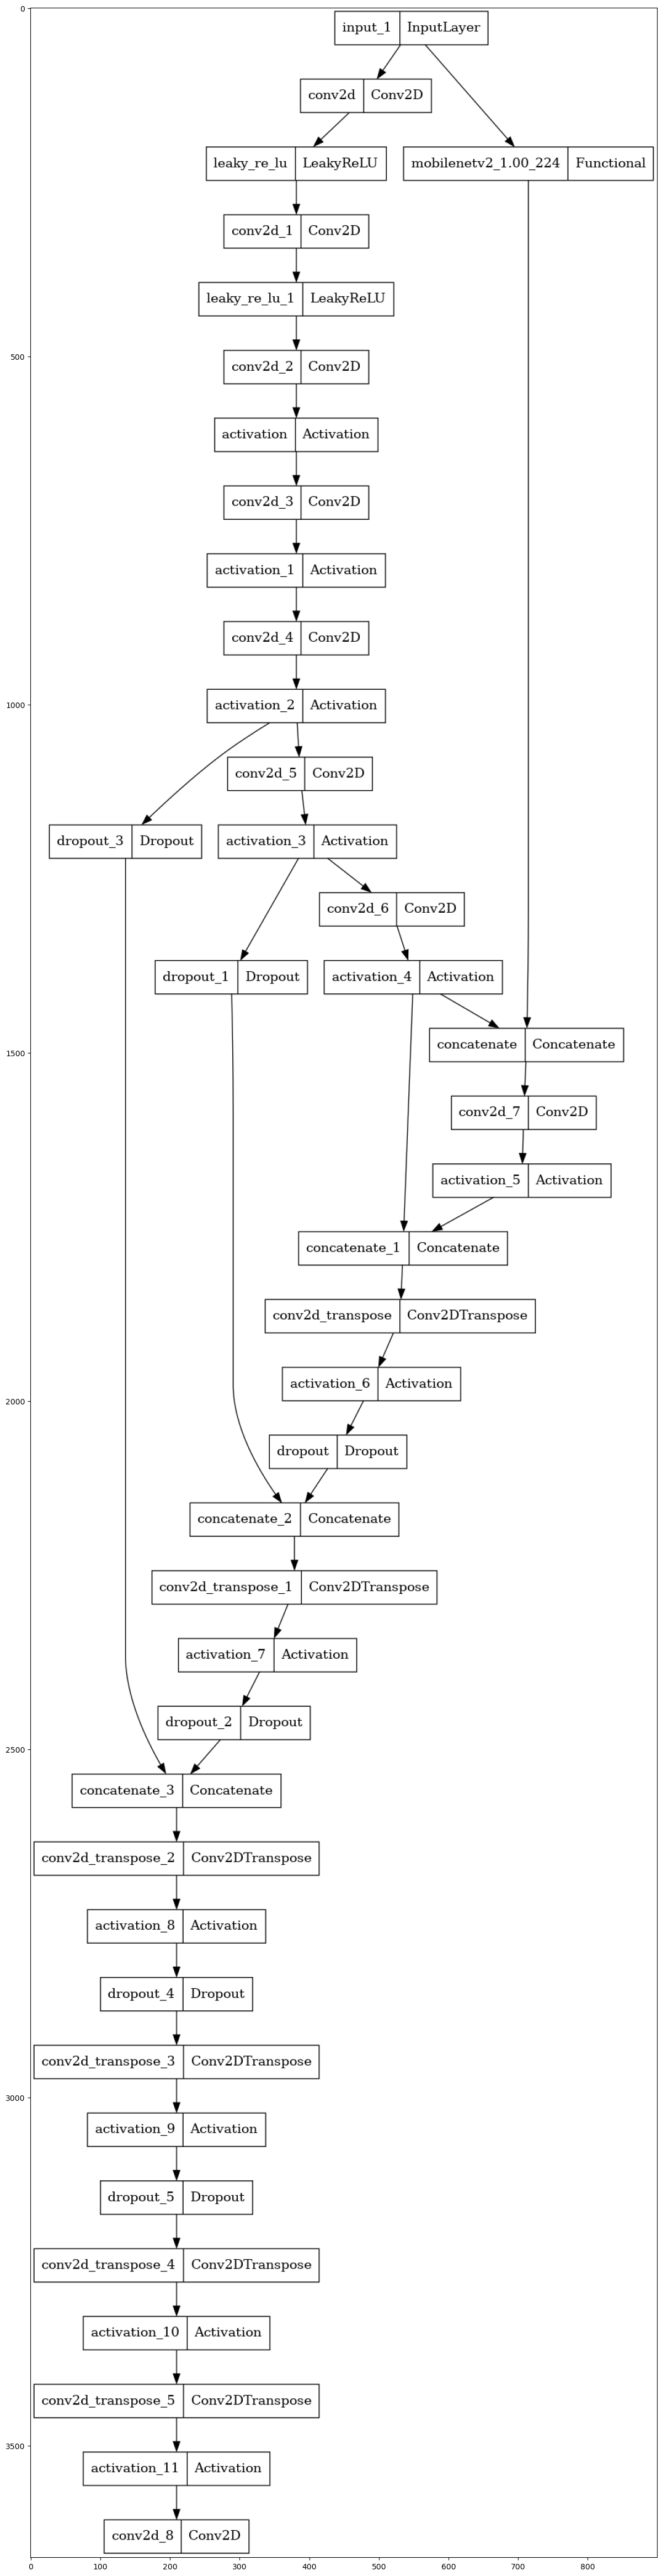

In [3]:
model = create_model((224, 224, 3))
plot_model(model, 'model_diagram.png')
plt.figure(figsize=(160, 60))
plt.imshow(Image.open('model_diagram.png'))

# Utility functions

In [4]:
def graph_training_data(epochs, training_data, validation_data, y_label, title):

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=np.arange(1, epochs+1), mode='lines+markers', y=training_data,
            marker=dict(color="mediumpurple"), name="Training"))

    fig.add_trace(
        go.Scatter(
            x=np.arange(1, epochs+1), mode='lines+markers', y=validation_data,
            marker=dict(color="forestgreen"), name="Validation"))

    fig.update_layout(title_text=title, yaxis_title=y_label,
                      xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [5]:
# Get prediction from the model based of the 'L' grayscale image
def get_pred(model, image_l):
    # Repeat the L value to match input shape
    image_l_R = np.repeat(image_l[..., np.newaxis], 3, -1)
    image_l_R = image_l_R.reshape((1, 224, 224, 3))
    # Normalize the input
    image_l_R = (image_l_R.astype('float32') - 127.5) / 127.5
    # Make prediction
    prediction = model.predict(image_l_R)
    # Normalize the output
    pred = (prediction[0].astype('float32') * 127.5) + 127.5
    
    return pred

In [6]:
# Combine an 'L' grayscale image with an 'AB' image, and convert to RGB for display or use
def get_LAB(image_l, image_ab):
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

In [7]:
# Create some samples of black and white images combined, to show input/output
def create_sample(model, images_gray, amount):
    path = "/kaggle/working/"
    samples = []
    for i in range(amount):
        # Select random images
        r = random.randint(0, images_gray.shape[0])
        # Get the model's prediction
        pred = get_pred(model, images_gray[r])
        # Combine input and output to LAB image
        image = get_LAB(images_gray[r], pred)
        # Get number of images in output folder
        count = len(os.listdir(path))
        # Create new combined image and save it
        new_image = Image.new('RGB', (448, 224))
        gray_image = Image.fromarray(images_gray[r])
        new_image.paste(gray_image, (0,0))
        new_image.paste(image, (224, 0))
        # Saving the image with the current count of images (to make it unique)
        # and the index of the image, so that it can be found if needed
        new_image.save(path + str(count)+('_%i.png' % r))
        samples.append(new_image)
    return samples

# Training function

Training is kept simple in this example, as it only uses ab1.
The model could be greatly improved from this example by managing the training to include ab2 and ab3. 

In [8]:
def train(model, gray, ab, epochs, batch_size):
    # Setup the training input data (grayscale images)
    train_in = gray
    # Convert the shape from (224, 224, 1) to (224, 224, 3) by copying the value to match MobileNet's requirements
    train_in = np.repeat(train_in[..., np.newaxis], 3, -1)
    
    train_out = ab
    # Normalize the data
    train_in = (train_in.astype('float32') - 127.5) / 127.5
    train_out = (train_out.astype('float32') - 127.5) / 127.5

    history = model.fit(
        train_in,
        train_out,
        epochs=epochs,
        validation_split=0.05,
        batch_size=batch_size
    )
    
    return history

# Main - Training the model

In this example the model is only trained using the first 3,000 images. It is recommended to use as many images as possible from the dataset to train the model. A script to manage that and RAM usage would be recommended. 

This example will only run on a small amount of data for few epochs, to facilitate the run in Kaggle, and simplify this notebook.

In [9]:
images_gray = np.load("/kaggle/input/image-colorization/l/gray_scale.npy")
images_ab = np.load("/kaggle/input/image-colorization/ab/ab/ab1.npy")

# Set batch size and epochs for training run
BATCH_SIZE = 32
EPOCHS = 5
# Create the model through the function above
model = create_model((224, 224, 3))

# Train the model and keep history for graphing
history = train(model, images_gray[:3000], images_ab[:3000], EPOCHS, BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


Epoch 1/5
90/90 [==============================] - 1344s 15s/step - loss: 0.0172 - accuracy: 0.5169 - val_loss: 0.0178 - val_accuracy: 0.5261
Epoch 2/5
90/90 [==============================] - 1273s 14s/step - loss: 0.0170 - accuracy: 0.5141 - val_loss: 0.0177 - val_accuracy: 0.5261
Epoch 3/5
90/90 [==============================] - 1270s 14s/step - loss: 0.0166 - accuracy: 0.5167 - val_loss: 0.0175 - val_accuracy: 0.5261
Epoch 4/5
90/90 [==============================] - 1259s 14s/step - loss: 0.0164 - accuracy: 0.5175 - val_loss: 0.0173 - val_accuracy: 0.5706
Epoch 5/5
90/90 [==============================] - 1251s 14s/step - loss: 0.0163 - accuracy: 0.5428 - val_loss: 0.0179 - val_accuracy: 0.5504


# Graphing the training data


In [10]:
graph_training_data(EPOCHS, history.history['loss'], history.history['val_loss'], 'Loss', "Loss while training")
graph_training_data(EPOCHS, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', "Accuracy while training")

# Creating Samples

Here are some images generated from the model through Kaggle, by the code shown above.

1/1 [==============================] - 0s 165ms/step


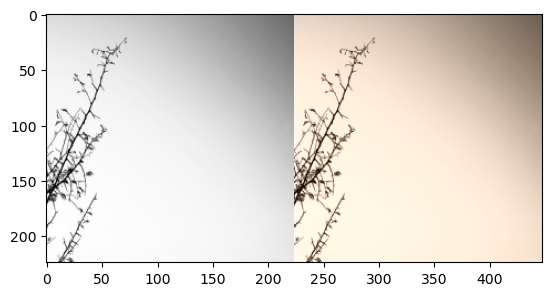

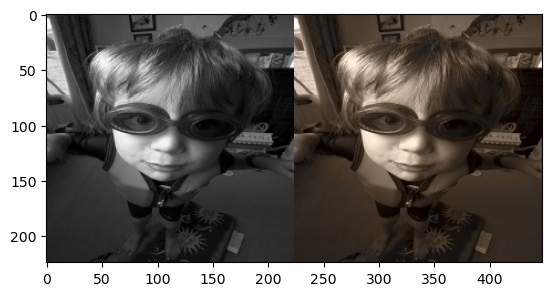

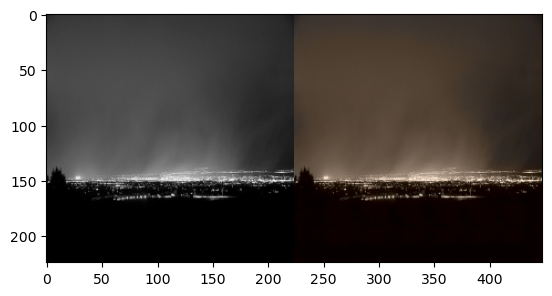

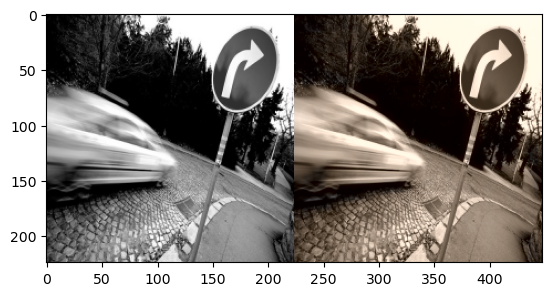

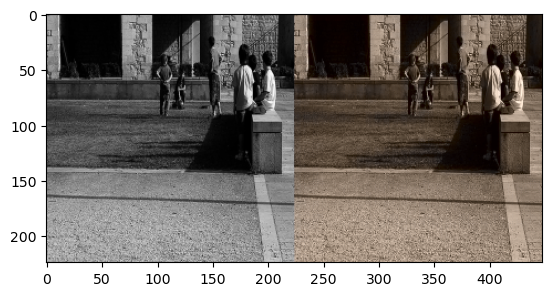

In [11]:
# Create 10 sample images. These images are both returned in a list, and saved.
samples = create_sample(model, images_gray, 5)
for image in samples:
    plt.figure()
    plt.imshow(np.array(image))

# Samples from better training

Here are some samples given by the same model but trained with more images from the dataset (using both ab1 and ab2), and trained for much longer.
The model was trained for around 10 hours over time, and using varying parts of the image dataset.

In [12]:
path = '/kaggle/imagecolorization-samplesmodel/ImageColorization_Samples'
success = os.listdir(path + '/Successful')
for img in success:
    plt.figure()
    plt.imshow(Image.open(path +'/Successful/' + img))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/imagecolorization-samplesmodel/ImageColorization_Samples/Successful'

In [ ]:
path = '../input/imagecolorization-samplesmodel/ImageColorization_Samples'
success = os.listdir(path + '/Failed')
for img in success:
    plt.figure()
    plt.imshow(Image.open(path +'/Failed/' + img))

In [ ]:
path = '../input/imagecolorization-samplesmodel/'
images = os.listdir(path)
for img in images:
    if (img == 'ImageColorization_Samples'): continue
    plt.figure()
    plt.imshow(Image.open(path + img))